# Imaging basics

In this notebook, we'll use the microscope gym API to perform basic imaging tasks like acquiring an image and moving the stage. We'll use the `mock_scope` microscope emulator, but the same commands should also work with any microscope adaptor that implements the microscope gym API.


In [1]:
from microscope_gym.mock_scope import microscope_factory
import pyclesperanto_prototype as cle
from pyclesperanto_prototype import imread

## Setting up a `mock_scope`

### Read the overview image that represents the entire sample

the mock_scope will later capture parts of this as the camera image

cl.OCLArray([[10451., 11537., 13573., ..., 11294., 10699., 12231.],
       [12580., 13126., 12886., ..., 12279., 12740., 11259.],
       [13772., 13406., 12923., ..., 14076., 12943., 12167.],
       ...,
       [12617., 12656., 12846., ..., 11671., 11674., 11123.],
       [14376., 12231., 11924., ..., 11739., 12539., 12025.],
       [13196., 14257., 12755., ..., 10963., 12206., 12208.]],
      dtype=float32)
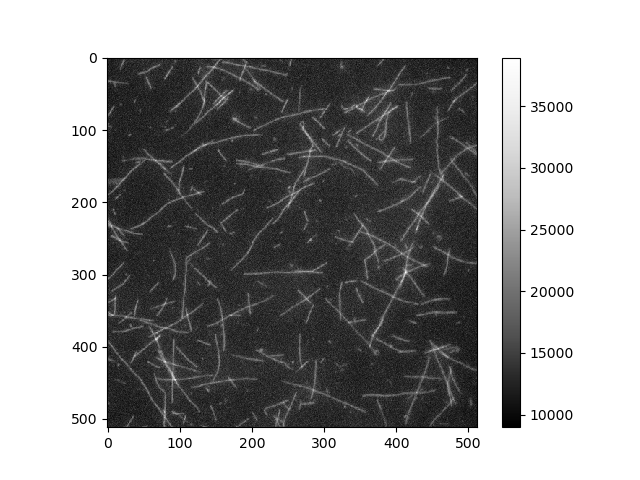
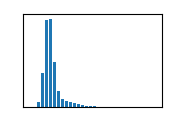

In [2]:
overview_image = imread("data/microtubules.tif")
overview_image

### Initialize the microscope

In [3]:
mock_scope = microscope_factory(overview_image=overview_image, camera_height_pixels=64, camera_width_pixels=64)
print('overview_image shape: ', mock_scope.camera.overview_image.shape)
print('camera height: ', mock_scope.camera.height_pixels)
print('camera width: ', mock_scope.camera.width_pixels)
print('stage position: ', mock_scope.get_stage_position())

overview_image shape:  (1, 512, 512)
camera height:  64
camera width:  64
stage position:  (223.5, 223.5, 0.0)


## Using the microscope

### Taking an image

cl.OCLArray([[12636., 12594., 14124., ..., 12056., 14434., 14918.],
       [13152., 12420., 13438., ..., 14179., 13960., 13371.],
       [13767., 13203., 16190., ..., 14167., 13246., 12880.],
       ...,
       [12622., 13899., 13086., ..., 12300., 14109., 13408.],
       [13395., 13681., 12911., ..., 13778., 13020., 12556.],
       [12892., 13139., 12753., ..., 13088., 14127., 13422.]],
      dtype=float32)
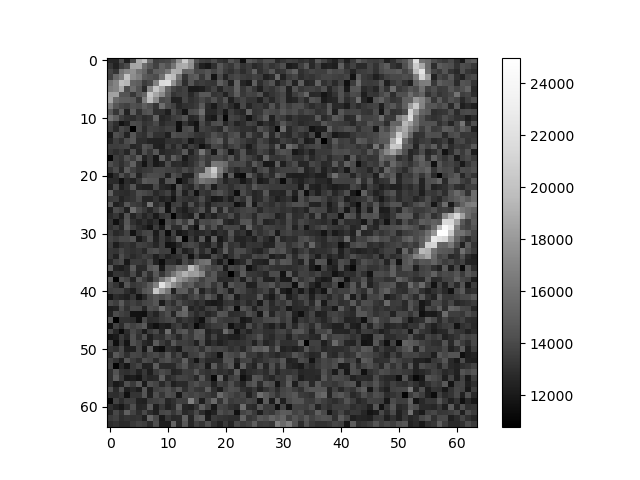
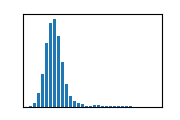

In [4]:
cle.asarray(mock_scope.capture_image())

Note that this image is from the center of the entire overview_image.

### Relative stage movement

We move the stage up by half a field-of-view and take another image

stage position:  (223.5, 191.5, 0.0)


cl.OCLArray([[13466., 11906., 13305., ..., 14265., 12731., 12033.],
       [12822., 12909., 13467., ..., 14612., 14181., 13862.],
       [14378., 12031., 14713., ..., 13546., 12691., 14530.],
       ...,
       [13032., 13497., 12602., ..., 14143., 13652., 14413.],
       [13582., 12671., 12956., ..., 16049., 15002., 13784.],
       [13826., 13455., 13972., ..., 13809., 12896., 13677.]],
      dtype=float32)
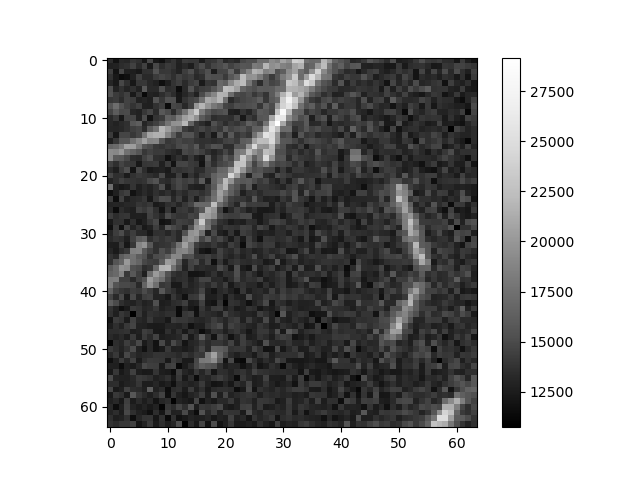
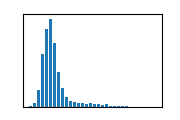

In [5]:
mock_scope.move_stage_by(0, -32, 0)
print('stage position: ', mock_scope.get_stage_position())
cle.asarray(mock_scope.capture_image())

### Absolute stage movement

We move the stage to the top left corner and take another image

stage position:  (0, 0, 0)


cl.OCLArray([[10451., 11537., 13573., ..., 12925., 12322., 14293.],
       [12580., 13126., 12886., ..., 13191., 13628., 14455.],
       [13772., 13406., 12923., ..., 16058., 13898., 13457.],
       ...,
       [12009., 12073., 12688., ..., 13040., 12852., 12947.],
       [12492., 13750., 11881., ..., 12263., 12547., 12397.],
       [10280., 11626., 12565., ..., 12205., 11957., 11722.]],
      dtype=float32)
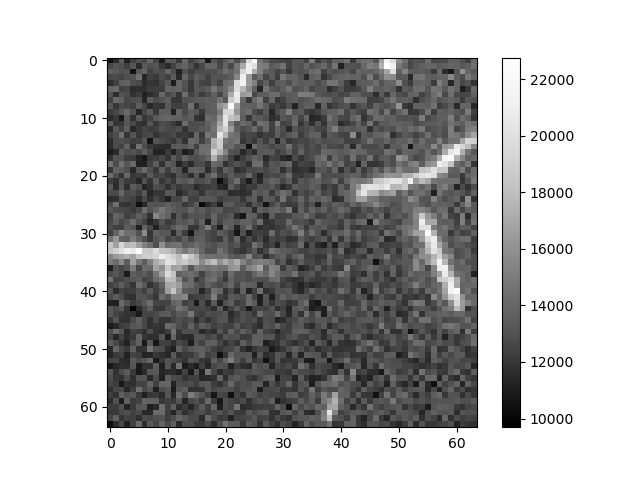
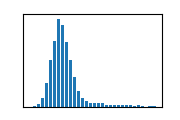

In [6]:
mock_scope.move_stage_to(0, 0, 0)
print('stage position: ', mock_scope.get_stage_position())
cle.asarray(mock_scope.capture_image())


## We cannot crash the stage

We get an error when trying to venture outside the safe stage range.

Let's look at the safe stage range:

In [7]:
print('safe stage range (x_range, y_range, z_range): ', mock_scope.stage.x_range, mock_scope.stage.y_range, mock_scope.stage.z_range)

safe stage range (x_range, y_range, z_range):  (0, 447) (0, 447) (0, 0)


We are already at position (0, 0, 0), so if we try to move further up or left, we'll get an error

In [8]:
# moving the stage up by 32 pixels fails because the stage is at the top of the safe range
mock_scope.move_stage_by(0, -32, 0)

ValueError: Y position out of range.

In [9]:
# moving the stage to position (448, 448, 0) fails because both x and y are outside the safe range
mock_scope.move_stage_to(448, 448, 0)

ValueError: X position out of range.